In [2]:
##Lib importing
import numpy as np
import time
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
from PIL import Image, ImageOps
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score,precision_score, recall_score , multilabel_confusion_matrix,classification_report
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

importing colab for storing dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


downloading dataset directly to drive

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ya30me","key":"2677faaa63230438f0317d7dc8f5161a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%cd /content/drive/MyDrive/DataSets/
!kaggle datasets download prashant268/chest-xray-covid19-pneumonia

/content/drive/MyDrive/DataSets
Dataset URL: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
License(s): unknown
chest-xray-covid19-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


unzipping the dataset

In [ ]:
path = '/content/drive/MyDrive/DataSets/'
import zipfile
with zipfile.ZipFile(path+'chest-xray-covid19-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall(path)


directory of datasets

In [ ]:
base_directory = '/content/drive/MyDrive/DataSets/Data'
train_path= '/content/drive/MyDrive/DataSets/Data/train'
test_path= '/content/drive/MyDrive/DataSets/Data/test'

the function for counting data, showing the format of data, and the disturbance histogram

In [1]:
def dataSet_analyzing (data_path):
    ##finding classes
    class_names=sorted(os.listdir(train_path))
    print(f'class of the dataset are:{class_names}')

    ##counting the examples
    data_counter=torch.zeros(len(class_names))
    #data_counter=0
    min_number=0
    i=0
    for className in class_names:
        class_path=os.path.join(data_path, className)
        imgs=([example for example in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, example))])
        data_counter[i]=len(imgs)
        print(f'number of examples for{className}class :{data_counter[i]}')
        for format in imgs:
            data_type=os.path.splitext(format)[1]
        print(f'data type is {data_type}')
        i+=1


    min_number=int(torch.min(data_counter).item())

    plt.figure(figsize=(8,5))
    plt.bar(class_names, data_counter)
    plt.title("Example per Class")
    plt.ylabel("Number of Examples")
    plt.xlabel("Class")

    plt.show()

    return class_names,min_number

analyzing both test and train data

class of the dataset are: ['COVID19', 'NORMAL', 'PNEUMONIA']
number of examples forCOVID19class :460.0
data type is .jpg
number of examples forNORMALclass :1266.0
data type is .jpg
number of examples forPNEUMONIAclass :3418.0
data type is .jpg


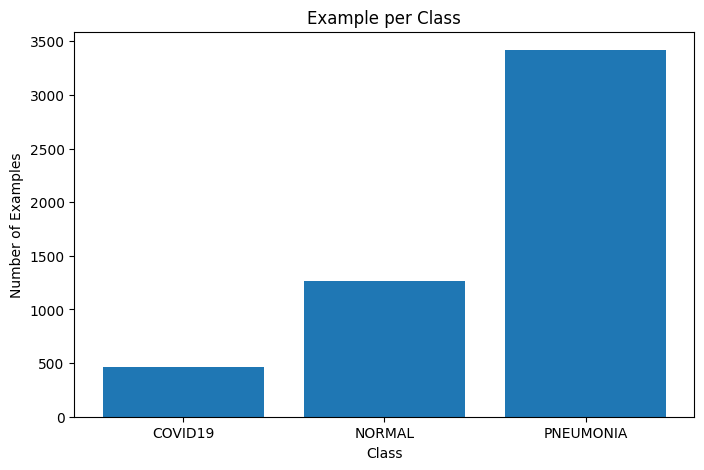

In [ ]:
classes_train,minValue_train=dataSet_analyzing(train_path)

class of the dataset are: ['COVID19', 'NORMAL', 'PNEUMONIA']
number of examples forCOVID19class :116.0
data type is .jpg
number of examples forNORMALclass :317.0
data type is .jpg
number of examples forPNEUMONIAclass :855.0
data type is .jpg


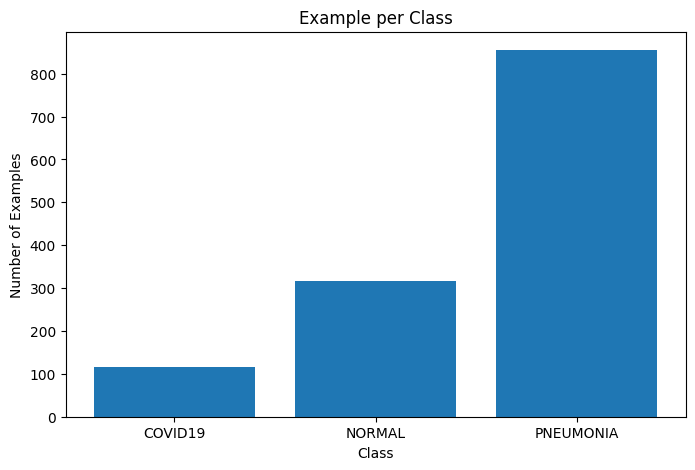

In [ ]:
classes_test,minValue_test=dataSet_analyzing(test_path)

DATA Augumentation

In [4]:

##making new data set

new_path_train='/content/drive/MyDrive/DataSets/Aug_Data/train'
new_path_test='/content/drive/MyDrive/DataSets/Aug_Data/test'

making new data by doing changes on original, saving new data and showing samples

In [ ]:
def dataSet_making(classes_name, min_value, first_path, new_path):

  random.seed(42)

  ##making th dataset bigger with augumentation, Data augmentation settings:# (n-1)
  Multiple_data=3  
  DataAugmentation_transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25),
        transforms.Resize((150, 150))
    ])


  for className in classes_name:
        class_path_old=os.path.join(first_path, className)
        class_path_new=os.path.join(new_path,className)
        os.makedirs(class_path_new,exist_ok=True)
        examples=os.listdir(class_path_old)
        random_example_images=random.sample(examples, min_value)

        for img_name in random_example_images:
            img_path =os.path.join(class_path_old, img_name)
            image=Image.open(img_path).convert('RGB')
            image=image.resize((150, 150))
            image.save(os.path.join(class_path_new, img_name))
            for i in range(Multiple_data):
               aug_image=DataAugmentation_transform(image)
               aug_name=f"{os.path.splitext(img_name)[0]}_aug{i+1}.jpg"
               aug_image.save(os.path.join(class_path_new, aug_name))

        ##plotting picture
        picture=os.listdir(class_path_new)
        plot_picture=[f for f in picture if f.endswith('_aug3.jpg')][:3]
        for i, pi in enumerate(plot_picture):
          img_path=os.path.join(class_path_new,pi)
          img=Image.open(img_path)
          plt.subplot(1, 3, i + 1)
          plt.imshow(img)
          plt.title(className)
        plt.show()

applying the Agumention on train and test data + showing a sample of images in folder

In [ ]:
dataSet_making(classes_train,minValue_train,train_path,new_path_train)#

NameError: name 'dataSet_making' is not defined

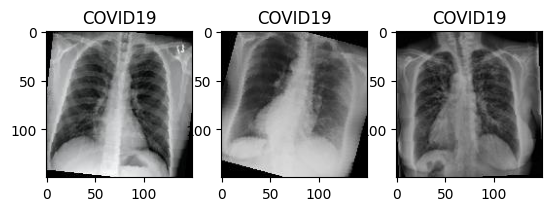

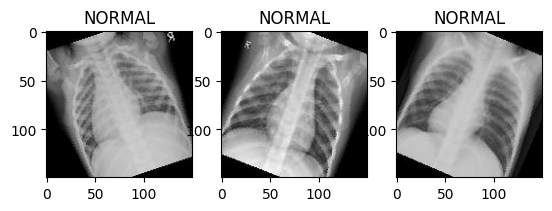

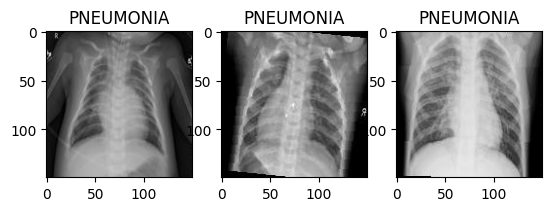

In [ ]:
dataSet_making(classes_test,minValue_test,test_path,new_path_test)

In [ ]:
!ls "/content/drive/MyDrive/DataSets/Aug_Data/train/COVID19"| head

COVID19(0)_aug1.jpg
COVID19(0)_aug2.jpg
COVID19(0)_aug3.jpg
COVID19(0).jpg
COVID19(100)_aug1.jpg
COVID19(100)_aug2.jpg
COVID19(100)_aug3.jpg
COVID19(100).jpg
COVID19(101)_aug1.jpg
COVID19(101)_aug2.jpg


Data Loader and validation set spliting

In [ ]:
## Data loader
transform=transforms.ToTensor()
df_X=datasets.ImageFolder(root=new_path_train, transform=transform)
validation_per=int(len(df_X) * 0.35)
train_per=len(df_X)-validation_per
train_data, val_data =random_split(df_X, [train_per, validation_per])
train_loader=DataLoader(train_data, batch_size=16, shuffle=True)
val_loader=DataLoader(val_data, batch_size=16, shuffle=False)

Paper model

In [ ]:
##model

class convolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    ##1
  
    self.conv1=nn.Conv2d(3,64,3,1,1)
    self.Batch1=nn.BatchNorm2d(64)
    self.drop1= nn.Dropout(0.2)

    ##2
    self.conv2=nn.Conv2d(64,64,3,1,1)
    self.Batch2=nn.BatchNorm2d(64)
    self.drop2= nn.Dropout(0.2)
    ##3
    self.conv3=nn.Conv2d(64,128,3,1,1)
    self.Batch3=nn.BatchNorm2d(128)
    self.drop3= nn.Dropout(0.2)
    ##4
    self.conv4=nn.Conv2d(128,128,3,1,1)
    self.Batch4=nn.BatchNorm2d(128)
    self.drop4= nn.Dropout(0.2)
    ##5
    self.conv5=nn.Conv2d(128,256,3,1,1)
    self.Batch5=nn.BatchNorm2d(256)
    self.drop5= nn.Dropout(0.2)
    ##6
    self.conv6=nn.Conv2d(256,256,3,1,1)
    self.Batch6=nn.BatchNorm2d(256)
    self.drop6= nn.Dropout(0.2)

    self.flatten=nn.Flatten()
    ##fully connected

    self.fc1=nn.Linear(256*2*2,512)
    self.Batchfc1=nn.BatchNorm1d(512)
    self.fc2=nn.Linear(512,256)
    self.Batchfc2=nn.BatchNorm1d(256)
    self.fc3=nn.Linear(256,3)

  def forward(self, X):
    ##1 CN
    X=self.conv1(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch1(X))

    X=self.drop1(X)


    ##2
    X=self.conv2(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch2(X))

    X=self.drop2(X)


    #3
    X=self.conv3(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch3(X))
    X=self.drop3(X)

    #4
    X=self.conv4(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch4(X))
    X=self.drop4(X)

    #5
    X=self.conv5(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch5(X))
    X=self.drop5(X)

    #6
    X=self.conv6(X)
    X=F.max_pool2d(X,2,2)
    X=F.relu(self.Batch6(X))
    X=self.drop6(X)

    ##Fc
    X=self.flatten(X)
    # fully connected layers
    X=F.relu(self.Batchfc1(self.fc1(X)))
    X=F.relu(self.Batchfc2(self.fc2(X)))
    X=self.fc3(X)
    X=F.sigmoid(X)
    #F.log_softmax(x, dim=1)


    return X

Model summery

In [ ]:
from torchsummary import summary
torch.manual_seed(42)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=convolutionalNetwork().to(device)
summary(model, input_size=(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
       BatchNorm2d-2           [-1, 64, 75, 75]             128
           Dropout-3           [-1, 64, 75, 75]               0
            Conv2d-4           [-1, 64, 75, 75]          36,928
       BatchNorm2d-5           [-1, 64, 37, 37]             128
           Dropout-6           [-1, 64, 37, 37]               0
            Conv2d-7          [-1, 128, 37, 37]          73,856
       BatchNorm2d-8          [-1, 128, 18, 18]             256
           Dropout-9          [-1, 128, 18, 18]               0
           Conv2d-10          [-1, 128, 18, 18]         147,584
      BatchNorm2d-11            [-1, 128, 9, 9]             256
          Dropout-12            [-1, 128, 9, 9]               0
           Conv2d-13            [-1, 256, 9, 9]         295,168
      BatchNorm2d-14            [-1, 25

loss function and optimizer

In [ ]:
#loss function
criterion=nn.BCELoss()

In [ ]:
## lr
from torch.optim.lr_scheduler import LinearLR
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

A function for calculating  f1,recall,..  

In [ ]:
##calculating f1,recall,..

def Show_Result_parameters(y_dataset, y_prediction):

    acc=accuracy_score(y_dataset,y_prediction)
    print(f'Accuracy Score:{acc:.4f}')
    f1=f1_score(y_dataset,y_prediction, average='macro', zero_division=0)
    print(f'F1 Score:{f1:.4f}')
    precision=precision_score(y_dataset, y_prediction, average='macro', zero_division=0)
    print(f'Precision Score:{precision:.4f}')
    recall=recall_score(y_dataset,y_prediction, average='macro', zero_division=0)
    print(f'Recall Score:{recall:.4f}')

one hotting function

In [ ]:
def one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels]

Training loops

In [ ]:

ENumbers=25
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]

for epoch in range(ENumbers):
    start_time=time.time()
    model.train()
    running_train_loss=0.0
    trn_correct=0
    trn_total=0

    for tr_images, tclasss in train_loader:
        tr_images, tclasss = tr_images.to(device), tclasss.to(device)

        
        tclasss_one_hot=one_hot(tclasss, 3).to(device).float()
        outputs=model(tr_images)
        loss=criterion(outputs, tclasss_one_hot)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss+=loss.item()

       
        predicts=torch.argmax(outputs, dim=1)
        trn_correct+=(predicts == tclasss).sum().item()
        trn_total+=tclasss.size(0)

    avg_train_loss=running_train_loss/len(train_loader)
    train_accuracy=trn_correct/trn_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    #val data set
    model.eval()
    running_val_loss=0.0
    val_correct=0
    val_total=0
    y_predict=[]
    y_val=[]

    with torch.no_grad():
        for Val_images, classs in val_loader:
            Val_images, classs = Val_images.to(device), classs.to(device)
            classs_one_hot = one_hot(classs, 3).to(device).float()
            outputs = model(Val_images)
            loss = criterion(outputs, classs_one_hot)
            running_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct+=(preds == classs).sum().item()
            val_total+=classs.size(0)

            y_predict.extend(preds.cpu())
            y_val.extend(classs.cpu())

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    current_time=time.time()
    total_time=current_time-start_time
    print(f'Epoch =[{epoch+1} in {ENumbers}] Training takes {total_time/60} minutes')
    print(f'learning rate {scheduler.get_last_lr()[0]:.6f}')
    print(f'Training Loss: {avg_train_loss:.4f} & Training Acc: {train_accuracy:.4f} ** Validation Loss: {avg_val_loss:.4f} & Validation Acc: {val_accuracy:.4f}')
    print('parameters:')
    Show_Result_parameters(y_val,y_predict)
    print('------------------------------------------------------------')

Epoch =[1 in 25] Training takes 24.005605113506316 minutes
learning rate 0.001000
Training Loss: 0.3031 & Training Acc: 0.8019 ** Validation Loss: 0.1725 & Validation Acc: 0.9057
parameters:
Accuracy Score:0.9057
F1 Score:0.9050
Precision Score:0.9081
Recall Score:0.9059
------------------------------------------------------------
Epoch =[2 in 25] Training takes 8.032289032141367 minutes
learning rate 0.001000
Training Loss: 0.1820 & Training Acc: 0.9016 ** Validation Loss: 0.1215 & Validation Acc: 0.9436
parameters:
Accuracy Score:0.9436
F1 Score:0.9437
Precision Score:0.9443
Recall Score:0.9435
------------------------------------------------------------
Epoch =[3 in 25] Training takes 9.591203892230988 minutes
learning rate 0.001000
Training Loss: 0.1547 & Training Acc: 0.9133 ** Validation Loss: 0.1555 & Validation Acc: 0.9120
parameters:
Accuracy Score:0.9120
F1 Score:0.9111
Precision Score:0.9167
Recall Score:0.9108
------------------------------------------------------------
Epo

In [ ]:
##saving the plotting variables
np.save("y_predict.npy", y_predict)
np.save("y_val.npy", y_val)
np.save('/content/drive/MyDrive/Hw2/STEp_y_predict.npy', y_predict)
np.save('/content/drive/MyDrive/Hw2/STEp_y_val.npy', y_val)
torch.save(model.state_dict(),'STEp_Xray_CNN_HW2.pt')
torch.save(model.state_dict(), "/content/drive/MyDrive/Hw2/STEp_Xray_CNN_HW2.pth")

plotting

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


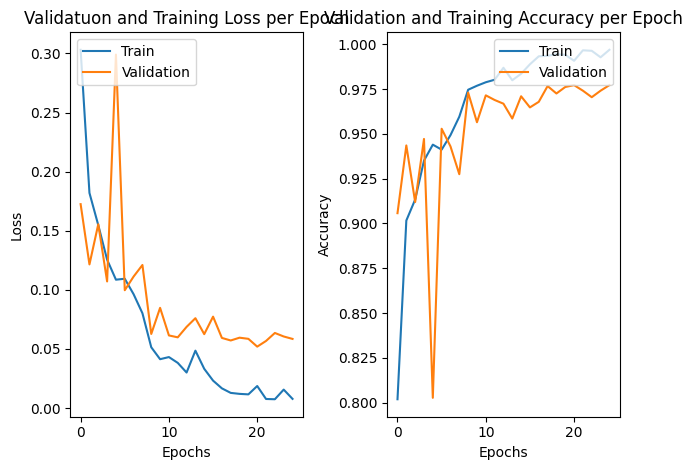

              precision    recall  f1-score   support

     COVID19       0.99      0.99      0.99       661
      NORMAL       0.97      0.98      0.97       626
   PNEUMONIA       0.97      0.96      0.97       644

    accuracy                           0.98      1931
   macro avg       0.98      0.98      0.98      1931
weighted avg       0.98      0.98      0.98      1931



In [ ]:
labels=df_X.classes
print(df_X.class_to_idx)
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validatuon and Training Loss per Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy per Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

print((classification_report(y_val,y_predict, target_names=labels)))

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


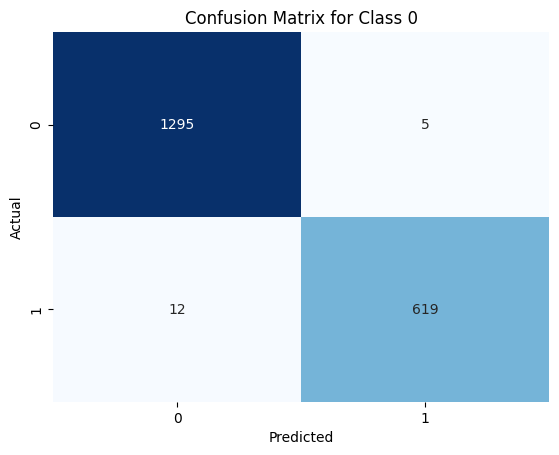

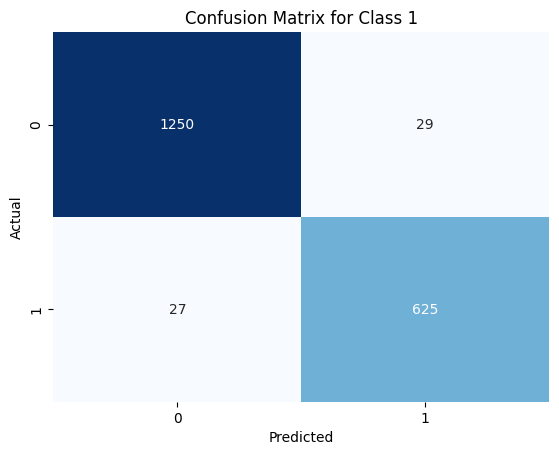

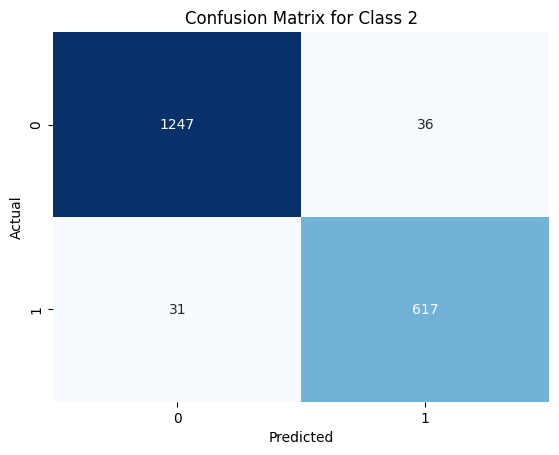

In [ ]:
ml_cm_1= multilabel_confusion_matrix(y_val,y_predict)
print(df_X.class_to_idx)
for i, cm in enumerate(ml_cm_1):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Testing model

In [7]:
##testing
testing_model=convolutionalNetwork()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
testing_model.load_state_dict(torch.load('/content/drive/MyDrive/Hw2/STEp_Xray_CNN_HW2.pth'))
testing_model.to(device)
testing_model.eval()

convolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch5): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

In [8]:
## Data loader
transform=transforms.ToTensor()
dfT_X=datasets.ImageFolder(root=new_path_test, transform=transform)
test_loader=DataLoader(dfT_X, batch_size=16, shuffle=False)
Test_labelclass=dfT_X.classes

In [9]:
#using model
test_predict=[]
test_y=[]

with torch.no_grad():
    for test_X, test_class in test_loader:
        test_X=test_X.to(device)
        test_class = test_class.to(device)

        outputs=testing_model(test_X)
        preds=torch.argmax(outputs, dim=1)  # convert sigmoid output to class label

        test_predict.extend(preds.cpu().numpy())
        test_y.extend(test_class.cpu().numpy())



In [10]:
np.save('/content/drive/MyDrive/Hw2/STEp_y_test.npy', np.array(test_y))
np.save('/content/drive/MyDrive/Hw2/STEp_y_test_preds.npy', np.array(test_predict))

In [11]:
print(classification_report(test_y, test_predict, target_names=Test_labelclass))


              precision    recall  f1-score   support

     COVID19       0.99      0.97      0.98       464
      NORMAL       0.92      0.91      0.91       464
   PNEUMONIA       0.91      0.94      0.92       464

    accuracy                           0.94      1392
   macro avg       0.94      0.94      0.94      1392
weighted avg       0.94      0.94      0.94      1392



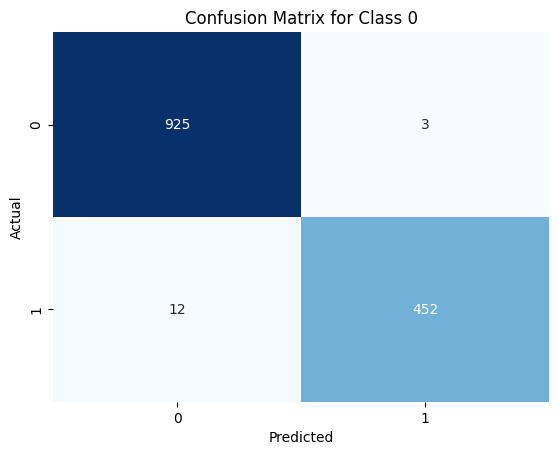

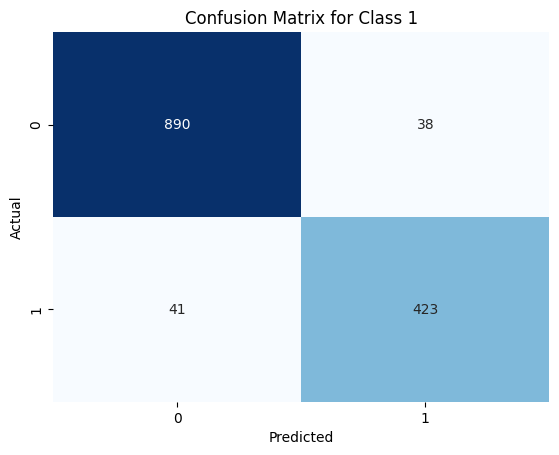

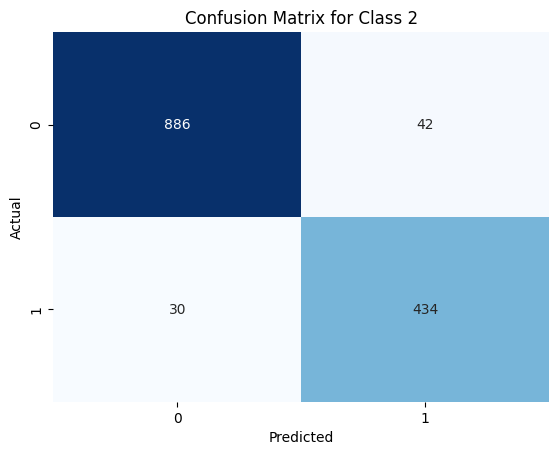

In [12]:
ml_cm_2= multilabel_confusion_matrix(test_y,test_predict)

for i, cm in enumerate(ml_cm_2):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()